In [1]:
import matplotlib.pyplot as plt

In [2]:
import numpy as np

In [3]:
import pathlib

In [4]:
import best

In [5]:
import sympy as sp

In [91]:
from scipy import optimize

In [6]:
class SemiAnalytical():
    def __init__(self, ells, MandelRep, Bvec):
                
        
        self.E = np.ones(6)
        self.P = self.getP()
        self.Q = self.getQ()
        
        self.invM = np.linalg.inv(MandelRep)
        self.Bvec = Bvec
        
        self.K = self.P+np.sqrt(2)*self.Q
        
        self.ells = ells
        
        self.C = np.einsum('i, ij -> j', self.E.T, K)
        
        self._create_stuff()
        
            
    def getP(self):
        P = np.zeros((6, 6))
        P[0, 0] = 1
        P[1, 1] = 1
        P[2, 2] = 1
        return P
    
    def getQ(self):
        Q = np.zeros((6, 6))
        Q[3, 3] = 1
        Q[4, 4] = 1
        Q[5, 5] = 1
        return Q
    
    
    def integrate(self, y, ells):
        factor = 4*np.pi
        return np.trapz(y*ells, ells)*(2*np.pi)/(2*np.pi)**2*factor
        
    def _create_stuff(self):
        P1 = np.zeros((6, 6))
        P1[0, 0] = 1

        P2 = np.zeros((6, 6))
        P2[0, 1] = 1

        P6 = np.zeros((6, 6))
        P6[0, 5] = 1

        Q = 2*P1.T@P2
        self.Z1 = Q-P6.T@P6
        self.Q1 = Q
        
        P1 = np.zeros((6, 6))
        P1[0, 0] = 1

        P3 = np.zeros((6, 6))
        P3[0, 2] = 1

        P5 = np.zeros((6, 6))
        P5[0, 4] = 1

        Q = 2*P1.T@P3
        self.Z2 = Q-P5.T@P5
        self.Q2 = Q
        
        P2 = np.zeros((6, 6))
        P2[0, 1] = 1

        P3 = np.zeros((6, 6))
        P3[0, 2] = 1

        P4 = np.zeros((6, 6))
        P4[0, 3] = 1

        Q = 2*P2.T@P3
        self.Z3 = Q-P4.T@P4
        self.Q3 = Q
        
    def _get_useful_matrices(self):
        Z1, Z2, Z3 = self.Z1, self.Z2, self.Z3
        
        invMandel = self.invM
        K = self.K
        C = self.C
        E = self.E
        
        Bvec = self.Bvec
        
        ells = self.ells
        
        return ells, Bvec, invMandel, Z1, Z2, Z3, K, C, E
        
    def getA0_function(self, FB):
        ells, Bvec, invMandel, Z1, Z2, Z3, K, C, E = self._get_useful_matrices()
            
        def getA0(x):
            l1, l2, l3 = x
            
            identity = np.diag(np.ones(6, dtype = float))
            R = identity+l1*Z1+l2*Z2+l3*Z3

            index = 1
            invMandel_selected = invMandel[index, :, :]

            invR = identity-l1*Z1+l2*Z2+l3*Z3 
            #invR = np.linalg.inv(R)

            MM = invR@invMandel_selected

            number = np.einsum('ij, jk, k, i', K, MM, C, E)
            Norm = self.integrate(number, ells)

            number = np.einsum('ij, jk, k, i', K, invMandel_selected, C, E)
            Normstd = self.integrate(number, ells)

            O = np.einsum('ij, jk, k, i', K, MM, Bvec[index], E)
            O = self.integrate(O, ells)

            Ofactor = np.einsum('ij, i, j', MM, C, Bvec[index])
            Ofactor = self.integrate(Ofactor, ells)

            Bfactor = np.einsum('ij, i, j', MM, Bvec[index], Bvec[index])
            Bfactor = self.integrate(Bfactor, ells)

            den = 1-FB*(O/Norm)*Ofactor+FB*Bfactor
            num = (Ofactor/Norm)*np.einsum('ij, j -> i', MM, (O/Norm)*C-Bvec[index])

            A0 = MM@C/Norm+FB*num/den

            return A0*Normstd #just to help a bit
        
        return getA0
        
        
        

In [7]:
SA = SemiAnalytical(ells, MandelMatrix, Bvec)

NameError: name 'ells' is not defined

In [ ]:
getA0 = SA.getA0_function(FB = 0.)

In [ ]:
def function(x):
    A0 = getA0(x)
    return abs(np.array([A0.T@SA.Z1@A0, A0.T@SA.Z2@A0, A0.T@SA.Z3@A0]))

result = optimize.root(function, np.array([0., 0., 0.]), method = 'hybr', 
                       options = {'maxfev': 10000, 'xtol': 1e-20, 'ftol': 1e-20})
result

In [8]:
P1 = np.zeros((6, 6))
P1[0, 0] = 1
#P1 = sp.Matrix(P1)

P2 = np.zeros((6, 6))
P2[0, 1] = 1
#P2 = sp.Matrix(P2)

P6 = np.zeros((6, 6))
P6[0, 5] = 1
#P6 = sp.Matrix(P6)

Q = 2*P1.T@P2
Z1 = Q-P6.T@P6

In [9]:
P1 = np.zeros((6, 6))
P1[0, 0] = 1
#P1 = sp.Matrix(P1)

P3 = np.zeros((6, 6))
P3[0, 2] = 1
#P3 = sp.Matrix(P2)

P5 = np.zeros((6, 6))
P5[0, 4] = 1
#P5 = sp.Matrix(P5)

Q = 2*P1.T@P3
Z2 = Q-P5.T@P5

In [10]:
P2 = np.zeros((6, 6))
P2[0, 1] = 1
#P2 = sp.Matrix(P1)

P3 = np.zeros((6, 6))
P3[0, 2] = 1
#P3 = sp.Matrix(P2)

P4 = np.zeros((6, 6))
P4[0, 3] = 1
#P4 = sp.Matrix(P4)

Q = 2*P2.T@P3
Z3 = Q-P4.T@P4

In [11]:
A0@Z2@A0

NameError: name 'A0' is not defined

In [12]:
A0[0]*A0[2]*2-A0[4]**2

NameError: name 'A0' is not defined

In [ ]:
Id = sp.Matrix(np.diag(np.ones(6)))

In [ ]:
l1 = sp.Symbol('\lambda_1')
l1

In [ ]:
l2 = sp.Symbol('\lambda_2')
l2

In [353]:
l3 = sp.Symbol('\lambda_3')
l3

\lambda_3

In [404]:
Z1 = sp.Matrix(Z1)
Z2 = sp.Matrix(Z2)
Z3 = sp.Matrix(Z3)

In [405]:
(Z1+Z2+Z3).diagonalize()

MatrixError: Matrix is not diagonalizable

In [406]:
l1*Z1+l2*Z2+l3*Z3

Matrix([
[0, 2.0*\lambda_1, 2.0*\lambda_2,              0,              0,              0],
[0,             0, 2.0*\lambda_3,              0,              0,              0],
[0,             0,             0,              0,              0,              0],
[0,             0,             0, -1.0*\lambda_3,              0,              0],
[0,             0,             0,              0, -1.0*\lambda_2,              0],
[0,             0,             0,              0,              0, -1.0*\lambda_1]])

In [407]:
Inv = (Id+l1*Z1+l2*Z2+l3*Z3).inv()

In [408]:
Inv.T*Z1*Inv

Matrix([
[0,                                     2.0,                                           -4.0*\lambda_3, 0, 0,                             0],
[0,                          -4.0*\lambda_1,                                  8.0*\lambda_1*\lambda_3, 0, 0,                             0],
[0, 8.0*\lambda_1*\lambda_3 - 4.0*\lambda_2, -2.0*\lambda_3*(8.0*\lambda_1*\lambda_3 - 4.0*\lambda_2), 0, 0,                             0],
[0,                                       0,                                                        0, 0, 0,                             0],
[0,                                       0,                                                        0, 0, 0,                             0],
[0,                                       0,                                                        0, 0, 0, -1.0/(1.0 - 1.0*\lambda_1)**2]])

In [409]:
import mystic.solvers as my
from mystic.coupler import and_, or_, not_
from mystic.constraints import and_ as _and, or_ as _or, not_ as _not

from mystic.monitors import VerboseMonitor

from mystic.penalty import linear_equality, quadratic_equality
from mystic.constraints import as_constraint

In [410]:
Z1 = np.array(Z1, dtype = float)

In [411]:
Z2 = np.array(Z2, dtype = float)

In [412]:
Z3 = np.array(Z3, dtype = float)

In [413]:
def function(l1, l2, l3):
    R = np.diag(np.ones(6))+l1*Z1+l2*Z2+l3*Z3
    print(l)
    A0 = np.linalg.inv(R)@invMandel[1, :, :]@C
    return abs(A0.T@Z1@A0)+abs(A0.T@Z2@A0)+abs(A0.T@Z3@A0)

In [414]:
import scipy.optimize as optimize

In [415]:
A0 = invMandel[1, :, :]@C

In [416]:
def functionA(A0):
    return [A0.T@Z1@A0, A0.T@Z2@A0, A0.T@Z3@A0]

In [417]:
A0.T@Z3@A0

8.816223846883769e-16

In [420]:
A0[0]*A0[2]*2-A0[4]**2

-2.2963402013242984e-16

In [421]:
functionA(A0)

[1.8070336198927226e-17, -2.2963402013242984e-16, 8.816223846883769e-16]

In [422]:
def function(x):
    l1, l2, l3 = x
    R = np.diag(np.ones(6, dtype = float))+l1*Z1+l2*Z2+l3*Z3
    
    A0 = np.linalg.inv(R)@invMandel[1, :, :]@C
    return [A0.T@Z1@A0, A0.T@Z2@A0, A0.T@Z3@A0]

In [439]:

optimize.root(function, np.array([0.1, 0.2, 0.3]), method = 'hybr', options = {'maxfevint': 1000, 'xtol': 1e-12})

/home/r/rbond/omard/.local/lib/python3.6/site-packages/ipykernel_launcher.py:1: OptimizeWarning: Unknown solver options: maxfevint
  """Entry point for launching an IPython kernel.


    fjac: array([[-2.05405915e-03,  9.99210839e-01, -3.96671127e-02],
       [-4.56717136e-02, -3.97195424e-02, -9.98166545e-01],
       [-9.98954391e-01, -2.38628111e-04,  4.57172576e-02]])
     fun: array([-1.10367705e-16, -2.29634020e-16,  2.21400860e-16])
 message: 'The iteration is not making good progress, as measured by the \n  improvement from the last ten iterations.'
    nfev: 97
     qtf: array([-2.38008433e-16, -2.06833291e-16,  1.20428941e-16])
       r: array([-4.20567478e+01, -2.45434533e+01, -7.38340887e+02,  2.45005029e+00,
       -1.82117548e+02,  2.07703531e-01])
  status: 5
 success: False
       x: array([1.27139663e-10, 7.51945355e-16, 3.75161535e-15])

In [440]:
function([1.27139663e-10, 7.51945355e-16, 3.75161535e-15])

[-1.1036770481296569e-16, -2.2963402013242984e-16, 2.2140085988511804e-16]

In [425]:
optimize.minimize(function, .1, bounds = [[0, 1]], method = 'SLSQP', options = {'ftol': 1e-11})

ValueError: not enough values to unpack (expected 3, got 1)

In [13]:
Tlabel = 'T'
Slabel = 'S'
Plabel = 'P'

In [14]:
cases = [Tlabel, Plabel, Slabel]

In [15]:
colors = {}
colors[Tlabel] = 'green'
colors[Plabel] = 'blue'
colors[Slabel] = 'orange'

In [16]:
p = pathlib.Path('../qelensingcomb/output/')
def getdir(l1, l2 = None, l3 = None):
    if (l2 is not None) and (l3 is not None):
        return f'h{l1}s{l2}b{l3}/tsz/'
    else:
        l = l1
        return f'h{l}s{l}b{l}/tsz/'

getT = lambda l1, l2, l3: np.load(p/getdir(l1, l2, l3)/'T_tsz_148.npy')#[index, index]
getP = lambda l1, l2, l3: np.load(p/getdir(l1, l2, l3)/'P_tsz_148.npy')#[index, index]
getS = lambda l1, l2, l3: np.load(p/getdir(l1, l2, l3)/'S_tsz_148.npy')#[index, index]
getells = lambda l1, l2, l3: np.load(p/getdir(l1, l2, l3)/'ells_tsz_148.npy')
getkk = lambda l1, l2, l3: np.load(p/getdir(l1, l2, l3)/'kk_tsz_148.npy')

In [17]:
l1, l2, l3 = 2500, 3000, 3000

In [18]:
ells = getells(l1, l2, l3)

In [19]:
sel = (ells>30) & (ells<1200)

In [20]:
ells = ells[sel]

In [21]:
clkk = getkk(l1, l2, l3)[sel]

In [22]:
theta = np.load(p/getdir(l1, l2, l3)/'theta_tsz_148.npy')[..., sel]

In [23]:
theta = theta/clkk**2.
theta = np.nan_to_num(theta)

In [24]:
N = np.load(p/getdir(l1, l2, l3)/'N_tsz_148.npy')[..., sel]

In [25]:
FB = 0.

In [26]:
indices_pairs = [(0, 0), (1, 1), (2, 2), (1, 2), (2, 0), (0, 1)]

In [27]:
MandelMatrix = np.ones((len(ells), 6, 6))

In [28]:
theta.shape

(3, 3, 3, 3, 8)

In [29]:
for A, pairA in enumerate(indices_pairs):
    for B, pairB in enumerate(indices_pairs):
        i, j = pairA
        m, n = pairB
        factorA = 1. if i == j else np.sqrt(2)
        factorB = 1. if m == n else np.sqrt(2)
        
        MandelMatrix[:, A, B] = factorA*factorB*theta[i, j, m, n]

In [30]:
B = getT(l1, l2, l3)+getP(l1, l2, l3)+getS(l1, l2, l3)
B = B[..., sel]/clkk

In [31]:
a_random = np.random.randn(3)

In [32]:
def getAmatrix(a):
    Avec = np.zeros(6)
    Avec[0] = a[0]**2
    Avec[1] = a[1]**2
    Avec[2] = a[2]**2
    Avec[3] = a[1]*a[2]*np.sqrt(2)
    Avec[4] = a[0]*a[2]*np.sqrt(2)
    Avec[5] = a[0]*a[1]*np.sqrt(2)
    return Avec

In [33]:
Avec_random = getAmatrix(a_random)

In [34]:
B[..., 0]

array([[-0.01245095, -0.00884403, -0.01000514],
       [-0.00884403, -0.00626215, -0.00771386],
       [-0.01000514, -0.00771386, -0.00927287]])

In [35]:
np.einsum('i, ij, j -> ', a_random, B[..., 0], a_random)

-0.07339220381642689

In [36]:
Avec = np.zeros((len(ells), 6))
Avec[:, 0] = B[0, 0]
Avec[:, 1] = B[1, 1]
Avec[:, 2] = B[2, 2]
Avec[:, 3] = B[1, 2]*np.sqrt(2)
Avec[:, 4] = B[0, 2]*np.sqrt(2)
Avec[:, 5] = B[0, 1]*np.sqrt(2)

In [37]:
Bvec = abs(Avec)
Bvecnonabs = Avec

In [38]:
kk = 1
MandelMatrix[kk, ...] == MandelMatrix[kk, ...].T

array([[ True,  True,  True,  True,  True,  True],
       [ True,  True,  True,  True,  True,  True],
       [ True,  True,  True,  True,  True,  True],
       [ True,  True,  True,  True,  True,  True],
       [ True,  True,  True,  True,  True,  True],
       [ True,  True,  True,  True,  True,  True]])

In [39]:
def is_pos_def(x):
    return np.all(np.linalg.eigvals(x) > 0)




In [40]:
is_pos_def(MandelMatrix[kk, ...] )

True

In [41]:
P1 = np.zeros((6, 6))
P1[0, 0] = 1
P1

array([[1., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0.]])

In [42]:
P2 = np.zeros((6, 6))
P2[0, 1] = 1
P2

array([[0., 1., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0.]])

In [43]:
P6 = np.zeros((6, 6))
P6[-1, -1] = 1
P6

array([[0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 1.]])

In [44]:
Aprova = np.array([1, 2, 3, 4, 5, 6])

In [45]:
Z = 2*P1.T@P2-P6
Zother = 2*P2.T@P1-P6

In [46]:
is_pos_def(Zother)

False

In [47]:
Z

array([[ 0.,  2.,  0.,  0.,  0.,  0.],
       [ 0.,  0.,  0.,  0.,  0.,  0.],
       [ 0.,  0.,  0.,  0.,  0.,  0.],
       [ 0.,  0.,  0.,  0.,  0.,  0.],
       [ 0.,  0.,  0.,  0.,  0.,  0.],
       [ 0.,  0.,  0.,  0.,  0., -1.]])

In [48]:
v = np.linalg.eig(Z)

In [49]:
np.linalg.matrix_rank(Z)

2

In [50]:
eigenvalues = v[0]
eigenvectors = v[1]

In [51]:
eigenvalues

array([ 0.,  0.,  0.,  0.,  0., -1.])

In [52]:
eigenvectors

array([[ 1.00000000e+000, -1.00000000e+000,  0.00000000e+000,
         0.00000000e+000,  0.00000000e+000,  0.00000000e+000],
       [ 0.00000000e+000,  3.00625254e-292,  0.00000000e+000,
         0.00000000e+000,  0.00000000e+000,  0.00000000e+000],
       [ 0.00000000e+000,  0.00000000e+000,  1.00000000e+000,
         0.00000000e+000,  0.00000000e+000,  0.00000000e+000],
       [ 0.00000000e+000,  0.00000000e+000,  0.00000000e+000,
         1.00000000e+000,  0.00000000e+000,  0.00000000e+000],
       [ 0.00000000e+000,  0.00000000e+000,  0.00000000e+000,
         0.00000000e+000,  1.00000000e+000,  0.00000000e+000],
       [ 0.00000000e+000,  0.00000000e+000,  0.00000000e+000,
         0.00000000e+000,  0.00000000e+000,  1.00000000e+000]])

In [54]:
P = np.zeros((6, 6))
P[0, 0] = 1
P[1, 1] = 1
P[2, 2] = 1
P

array([[1., 0., 0., 0., 0., 0.],
       [0., 1., 0., 0., 0., 0.],
       [0., 0., 1., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0.]])

In [55]:
Q = np.zeros((6, 6))
Q[3, 3] = 1
Q[4, 4] = 1
Q[5, 5] = 1
Q

array([[0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 1., 0., 0.],
       [0., 0., 0., 0., 1., 0.],
       [0., 0., 0., 0., 0., 1.]])

In [56]:
E = np.ones(6)

In [57]:
C = np.einsum('i, ij -> j', E.T, P)+np.sqrt(2)*np.einsum('i, ij -> j', E.T, Q)#E.T@P+np.sqrt(2)*E.T@Q
C

array([1.        , 1.        , 1.        , 1.41421356, 1.41421356,
       1.41421356])

In [58]:
invMandel = np.zeros_like(MandelMatrix)

In [59]:
invMandel = np.linalg.inv(MandelMatrix)

In [60]:
def integrate_discrete(y, ells):
    #Nmodes = lEdges[1:]**2. - lEdges[:-1]**2
    factor = 4*np.pi
    return np.trapz(y*ells, ells)*(2*np.pi)/(2*np.pi)**2*factor

In [61]:
number = np.einsum('ij, ...jk, k, i', (P+np.sqrt(2)*Q), invMandel, C, E)
Norm = integrate_discrete(number, ells)

In [62]:
O = np.einsum('ij, ...jk, ...k, i', (P+np.sqrt(2)*Q), invMandel, Bvec, E)
O = integrate_discrete(O, ells)

In [63]:
Ofactor = np.einsum('...ij, j, ...i', invMandel, C, Bvec)
Ofactor = integrate_discrete(Ofactor, ells)

In [64]:
Ofactornonabs = np.einsum('...ij, j, ...i', invMandel, C, Bvecnonabs)
Ofactornonabs = integrate_discrete(Ofactornonabs, ells)

In [65]:
Bfactor = np.einsum('...ij, ...j, ...i -> ...', invMandel, Bvec, Bvec)
Bfactor = integrate_discrete(Bfactor, ells)

In [66]:
den = 1-(FB)*(O/Norm)*Ofactor+(FB)*Bfactor
den

1.0

In [67]:
bias = 1/den*(1/Norm)*Ofactor
bias

0.00923765466975292

In [68]:
invMandel.shape

(8, 6, 6)

In [69]:
lambda_over_2 = (1+FB*bias*O)/Norm

In [70]:
K = (P+np.sqrt(2)*Q)

In [71]:
number = np.einsum('ij, ...jk, k, i', K, invMandel, C, E)
Norm = integrate_discrete(number, ells)

In [72]:
O = np.einsum('ij, ...jk, ...k, i', K, invMandel, Bvec, E)
O = integrate_discrete(O, ells)

In [73]:
FB = 0.

In [74]:
def getstandardA0():
    
    invMandel_selected = invMandel[1, :, :]

    MM = invMandel_selected
    
    number = np.einsum('ij, ...jk, k, i', K, MM, C, E)
    Norm = integrate_discrete(number, ells)
    
    O = np.einsum('ij, ...jk, ...k, i', K, MM, Bvec, E)
    O = integrate_discrete(O, ells)

    A0 = MM@C/Norm
 
    return A0

In [75]:
def getA0(x):
    l1, l2, l3 = x
    R = np.diag(np.ones(6, dtype = float))+l1*Z1+l2*Z2+l3*Z3
    
    index = 1
    invMandel_selected = invMandel[index, :, :]
    
    #invR = np.diag(np.ones(6, dtype = float))-l1*Z1+l2*Z2+l3*Z3 
    invR = np.linalg.inv(R)
    
    MM = invR@invMandel_selected
    
    number = np.einsum('ij, jk, k, i', K, MM, C, E)
    Norm = integrate_discrete(number, ells)
    
    number = np.einsum('ij, jk, k, i', K, invMandel_selected, C, E)
    Normstd = integrate_discrete(number, ells)
    
    O = np.einsum('ij, jk, k, i', K, MM, Bvec[index], E)
    O = integrate_discrete(O, ells)
    
    Ofactor = np.einsum('ij, i, j', MM, C, Bvec[index])
    Ofactor = integrate_discrete(Ofactor, ells)
    
    Bfactor = np.einsum('ij, i, j', MM, Bvec[index], Bvec[index])
    Bfactor = integrate_discrete(Bfactor, ells)
    
    den = 1-FB*(O/Norm)*Ofactor+FB*Bfactor
    num = (Ofactor/Norm)*np.einsum('ij, j -> i', MM, (O/Norm)*C-Bvec[index])

    A0 = MM@C/Norm+FB*num/den
 
    return A0*Normstd

In [76]:
def getA0v2(x):
    l1, l2, l3 = x
    R = np.diag(np.ones(6, dtype = float))+l1*Z1+l2*Z2+l3*Z3
    
    index = 1
    invMandel_selected = invMandel[index, :, :]
    
    invR = np.linalg.inv(R)
    
    MM = invMandel_selected
    
    vettore = MM@C
    invvettore = np.linalg.solve(R, vettore)
    
    number = np.einsum('ij, j, i', K, invvettore, E)
    Norm = integrate_discrete(number, ells)
    
    number = np.einsum('ij, jk, k, i', K, invMandel_selected, C, E)
    Normstd = integrate_discrete(number, ells)
    
    vettore = MM@Bvec[index]
    invvettore = np.linalg.solve(R, vettore)
    O = np.einsum('ij, j, i', K, invvettore, E)
    O = integrate_discrete(O, ells)
    
    vettore = MM@C
    invvettore = np.linalg.solve(R, vettore)
    Ofactor = np.einsum('i, i', invvettore, Bvec[index])
    Ofactor = integrate_discrete(Ofactor, ells)
    
    vettore = MM@Bvec[index]
    invvettore = np.linalg.solve(R, vettore)
    Bfactor = np.einsum('i, i', invvettore, Bvec[index])
    Bfactor = integrate_discrete(Bfactor, ells)
    
    den = 1-FB*(O/Norm)*Ofactor+FB*Bfactor
    vettore = MM@((O/Norm)*C-Bvec[index])
    invvettore = np.linalg.solve(R, vettore)
    num = (Ofactor/Norm)*invvettore

    A0 = MM@C/Norm+FB*num/den
 
    return A0*Normstd

In [77]:
def getNormStd():

    invMandel_selected = invMandel
    

    
    number = np.einsum('ij, ...jk, k, i -> ...', K, invMandel_selected, C, E)
    Normstd = integrate_discrete(number, ells)

 
    return Normstd

In [126]:
def getA0withindex(FB):
    def getA0(x):
        newx = x.reshape((len(ells), 3))
        l1, l2, l3 = newx[:, 0], newx[:, 1], newx[:, 2]
        
        part = np.einsum('..., ...ij, jk -> ...ik', l1, invMandel, Z1)
        part += np.einsum('..., ...ij, jk -> ...ik', l2, invMandel, Z2)
        part += np.einsum('..., ...ij, jk -> ...ik', l3, invMandel, Z3)
        
        identity = np.diag(np.ones(6, dtype = float))
        R = identity-part
        
        invMandel_selected = invMandel

        invR = np.linalg.inv(R)

        MM = np.einsum('...ij, ...jk -> ...ik', invR, invMandel_selected)
        
        number = np.einsum('ij, ...jk, k, i -> ...', K, MM, C, E)
        Norm = integrate_discrete(number, ells)

        number = np.einsum('ij, ...jk, k, i -> ...', K, invMandel_selected, C, E)
        Normstd = integrate_discrete(number, ells)

        O = np.einsum('ij, ...jk, ...k, i -> ...', K, MM, Bvec, E)
        O = integrate_discrete(O, ells)

        Ofactor = np.einsum('...ij, j, ...i -> ...', MM, C, Bvec)
        Ofactor = integrate_discrete(Ofactor, ells)

        Bfactor = np.einsum('...ij, ...j, ...i -> ...', MM, Bvec, Bvec)
        Bfactor = integrate_discrete(Bfactor, ells)

        den = 1-FB*(O/Norm)*Ofactor+FB*Bfactor
        
        num = (Ofactor/Norm)*np.einsum('...ij, ...j -> ...i', MM, (O/Norm)*C-Bvec)

        A0 = MM@C/Norm+FB*num/den

        return A0*Normstd
    return getA0

In [ ]:
M-li*Zi

In [174]:
is_pos_def(MandelMatrix-result.x[0]*Z1)

False

In [169]:
np.linalg.eigvals(MandelMatrix).shape

(8, 6)

In [167]:
is_pos_def??

Signature: is_pos_def(x)
Docstring: <no docstring>
Source:   
def is_pos_def(x):
    return np.all(np.linalg.eigvals(x) > 0)
File:      /gpfs/fs0/scratch/r/rbond/omard/CORI17112020/qelensingcomb/<ipython-input-39-1c3b060f2f7d>
Type:      function


In [110]:
def gettotal(A0, FB):
    total = 0
    variance = np.einsum('...i, ...ik, ...k -> ...', A0, MandelMatrix, A0)
    variance = integrate_discrete(number, ells)
    bias = np.einsum('...i, ...i -> ...', A0, Bvec)
    bias = integrate_discrete(bias, ells)
    total = variance+FB*bias**2.
    return total

#Idea is to find the lambdas while minizing for total functional

In [80]:
SA = SemiAnalytical(ells, MandelMatrix, Bvec)

In [177]:
Q1 = (SA.Q1+SA.Q1.T)/2
Q2 = (SA.Q2+SA.Q2.T)/2
Q3 = (SA.Q3+SA.Q3.T)/2


Z1 = (SA.Z1+SA.Z1.T)/2
Z2 = (SA.Z2+SA.Z2.T)/2
Z3 = (SA.Z3+SA.Z3.T)/2

In [178]:
def per_l(A0):
        one = abs(np.einsum('...i, ij, ...j -> ...', A0, Z1, A0))
        two = abs(np.einsum('...i, ij, ...j -> ...', A0, Z2, A0))
        three = abs(np.einsum('...i, ij, ...j -> ...', A0, Z3, A0))
        return np.c_[one, two, three]

In [179]:
def per_l_mod(A0):
        one = abs(np.einsum('...i, ij, ...j -> ...', A0, (Z1-Q1), A0)/np.einsum('...i, ij, ...j -> ...', A0, Q1, A0))
        two = abs(np.einsum('...i, ij, ...j -> ...', A0, (Z2-Q2), A0)/np.einsum('...i, ij, ...j -> ...', A0, Q2, A0))
        three = abs(np.einsum('...i, ij, ...j -> ...', A0, (Z3-Q3), A0)/np.einsum('...i, ij, ...j -> ...', A0, Q3, A0))
        arr = np.append(np.append(one, two), three)-1
        return abs(arr)

In [180]:
def function_per_l(x, mod = False):
        A0 = getA0(x)
        return per_l(A0) if not mod else per_l_mod(A0)

In [181]:
def function(x, mod = False):
        return function_per_l(x, mod).flatten()

In [182]:
old = np.zeros(3*8)

In [183]:
getA0 = getA0withindex(FB = 0.1)

In [184]:
result = optimize.root(function, np.array(old), method = 'hybr', 
                       options = {'maxfev': 10000, 'xtol': 1e-6, 'ftol': 1e-14})
result.success

/home/r/rbond/omard/.local/lib/python3.6/site-packages/ipykernel_launcher.py:2: OptimizeWarning: Unknown solver options: ftol
  


False

In [185]:
allresults = getA0(result.x)/getNormStd()

In [186]:
check = np.einsum('ij, ...j -> ...i', (P+np.sqrt(2)*Q), allresults)
check = np.einsum('...i, i -> ...', check, E)
print(check.shape)
integrate_discrete(check, ells)

(8,)


0.9999999999996559

In [187]:
old = result.x
old

array([-2.66635870e-01,  1.30413167e-01,  1.04234329e-01, -1.78856700e-01,
        8.60082701e-02,  1.44806686e-01, -2.93119514e-01,  1.41319656e-01,
        9.83932811e-02, -2.20355504e+01,  2.65395292e+00, -2.81793570e+00,
       -3.36502606e+00,  4.17020203e-01, -1.78665723e+00, -3.10679305e+02,
        1.09260525e+01,  4.23006310e+01,  4.73187606e+02,  1.23864204e+02,
       -4.60002151e+01, -1.00679563e+03,  1.55882468e+02,  1.82490374e+02])

In [188]:
function(result.x)

array([3.14271337e-03, 9.63440134e-03, 4.88070889e-02, 7.87177846e-03,
       8.50064288e-03, 1.34775316e-02, 8.81438489e-05, 3.81962470e-04,
       1.71048187e-03, 3.13108821e-04, 3.32220872e-03, 1.49994794e-03,
       1.00514686e-03, 2.79661923e-03, 1.79504757e-03, 4.09931254e-06,
       1.23418404e-04, 2.83672384e-05, 1.10473837e-06, 4.10876265e-06,
       3.10109983e-05, 1.41879338e-07, 2.80301094e-07, 3.17211773e-07])

In [189]:
AA = getA0(result.x)
AA[:, 0]*AA[:, 1]*2/AA[:, 5]**2

array([-1.37639341e+02,  5.58859289e-02,  2.86937028e-01, -8.41675154e+02,
       -9.36022864e+00,  2.98537823e+02, -1.74983524e+04,  1.58468965e-01])

In [102]:
def get_constr(i):
    return lambda x: function_per_l(x, mod = False)[i]

constrs = [{'type': 'eq', 'fun': get_constr(i)} for i in range(3*8)]

In [103]:
constrf = lambda x: function(x, mod = False)

constrs = [{'type': 'eq', 'fun': constrf}]

In [111]:
FB = 0.

In [112]:
getA0 = getA0withindex(FB = FB)

In [113]:
f = lambda x: gettotal(getA0(x), FB)

In [114]:
resultf = optimize.minimize(f, resultf.x*0 , constraints = constrs)
resultf

     fun: 14435.239692675012
     jac: array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0.])
 message: 'Optimization terminated successfully.'
    nfev: 26
     nit: 1
    njev: 1
  status: 0
 success: True
       x: array([ 0., -0., -0., -0., -0., -0.,  0., -0., -0., -0., -0.,  0.,  0.,
       -0.,  0., -0., -0.,  0., -0., -0.,  0., -0.,  0., -0.])

In [125]:
oldf = np.zeros(3*8)
methodA = 'trust-constr'
methodB = 'SLSQP'
method = methodB

for i in range(5000):
    step = 0.0005
    getA0 = getA0withindex(FB = 0.0+i*step)
    f = lambda x: gettotal(getA0(x)/getNormStd(), FB)
    def function_per_l(x):
        A0 = getA0(x)
        return per_l(A0)
    def function(x):
        return function_per_l(x).flatten()
    constrf = lambda x: function(x)
    constrs = [{'type': 'eq', 'fun': constrf}]
    
    resultf = optimize.minimize(f, oldf , constraints = constrs, method = method)
    oldf = resultf.x
    #print(resultf.success)
    if not resultf.success:
        print('Breaking')
        print(resultf.message)
        break
print(i, i*step)

Breaking
Iteration limit exceeded
1 0.0005


In [116]:
step*5000

0.025

In [2538]:
#resultf = optimize.minimize(f, oldf , constraints = constrs)
#resultf

In [122]:
constrf(resultf.x)

array([3.64175066e-08, 2.15576448e-02, 1.22965586e-04, 1.33102705e-08,
       1.75044274e-03, 4.57342178e-06, 7.57662209e-10, 6.56474529e-06,
       1.31416659e-07, 1.07785261e-09, 7.21916439e-07, 1.34322144e-08,
       1.16983512e-10, 1.66841118e-07, 8.36309006e-10, 9.96355015e-11,
       1.02440477e-08, 8.40801582e-10, 3.85505049e-12, 1.02987492e-09,
       1.65955811e-10, 9.53483465e-14, 1.03819741e-10, 1.74308140e-11])

In [123]:
AA = getA0(resultf.x)
AA[:, 0]*AA[:, 1]*2/AA[:, 5]**2

array([-1.48076118e+05,  1.46380635e+03, -1.98051561e+06,  9.65536859e-01,
        9.67737763e-01,  9.92269193e-01,  9.96517871e-01,  9.73277469e-01])

In [2542]:
allresults = getA0(resultf.x)/getNormStd() #getA0(result.x)/getNormStd()

In [2543]:
w_from_prime = allresults[:, 0:3].sum(axis = 1)+np.sqrt(2)*allresults[:, 3:6].sum(axis = 1)
w_from_prime

array([1.75970556e-05, 1.60176704e-05, 1.24145749e-05, 8.30960614e-06,
       3.59865697e-06, 1.43180621e-06, 4.74697023e-07, 1.36802873e-07])

In [2544]:
mvVector = lambda_over_2*np.einsum('...ij, j -> ...i', invMandel, C)
wLcalculated = mvVector[:, 0:3].sum(axis = 1)+np.sqrt(2)*mvVector[:, 3:6].sum(axis = 1)
wLcalculated

array([1.76086057e-05, 1.58148116e-05, 1.22964332e-05, 8.24971627e-06,
       3.59011312e-06, 1.43713699e-06, 4.80646367e-07, 1.41691773e-07])

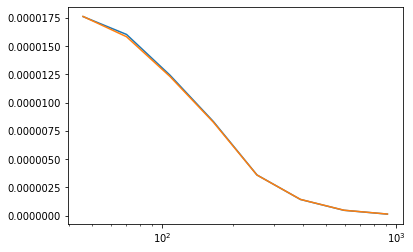

In [2545]:
plt.plot(ells, w_from_prime)
plt.plot(ells, wLcalculated)
plt.xscale('log')

In [1735]:
check = np.einsum('ij, ...j -> ...i', (P+np.sqrt(2)*Q), allresults)
check = np.einsum('...i, i -> ...', check, E)
print(check.shape)
integrate_discrete(check, ells)

(8,)


1.0000000000000187

In [1736]:
check = np.einsum('ij, ...j -> ...i', (P+np.sqrt(2)*Q), mvVector)
check = np.einsum('...i, i -> ...', check, E)
print(check.shape)
integrate_discrete(check, ells)

(8,)


1.0000000000000062

In [1737]:
a1 = np.sqrt(allresults[:, 0]/w_from_prime)
a2 = np.sqrt(allresults[:, 1]/(w_from_prime))
a3 = np.sqrt(allresults[:, 2]/(w_from_prime))
a1+a2+a3

/home/r/rbond/omard/.local/lib/python3.6/site-packages/ipykernel_launcher.py:1: RuntimeWarning: invalid value encountered in sqrt
  """Entry point for launching an IPython kernel.
/home/r/rbond/omard/.local/lib/python3.6/site-packages/ipykernel_launcher.py:2: RuntimeWarning: invalid value encountered in sqrt
  


array([       nan,        nan,        nan, 1.01168623, 0.86266051,
              nan,        nan,        nan])

In [1456]:
allresults[:, 0]*allresults[:, 1]*2/allresults[:, 5]**2

array([ 3.06668402e+00,  5.03055936e-03, -1.23616930e+00,  3.69471362e-01,
       -6.13607462e+00,  5.79958446e-01, -5.33964286e-01,  1.63035439e-01])

In [1144]:
result

    fjac: array([[-1.00000000e+00, -3.16067977e-10, -4.58581922e-11],
       [ 3.18544125e-10, -9.97421326e-01, -7.17683600e-02],
       [ 2.30562759e-11,  7.17683600e-02, -9.97421326e-01]])
     fun: array([-1.66126433e-67, -1.73479572e-64, -3.07029539e-65])
 message: 'The iteration is not making good progress, as measured by the \n  improvement from the last ten iterations.'
    nfev: 18
     qtf: array([1.66126489e-67, 1.75235725e-64, 1.81734367e-65])
       r: array([ 4.06882520e-74,  2.09082465e-76,  2.04364940e-74,  2.20510992e-76,
       -4.80360538e-76, -3.61961890e-77])
  status: 5
 success: False
       x: array([2.98718331e+10, 2.98718331e+10, 5.97436662e+10])

In [1145]:
w_from_prime = (allresults[:, 0]+allresults[:, 1]+allresults[:, 2])**2
w_from_prime

array([7.16972284e-39, 7.20322930e-13, 6.31229704e-13, 7.03753431e-13,
       3.15650594e-49, 5.15454687e-55, 1.26543217e-12, 2.82258267e-56])

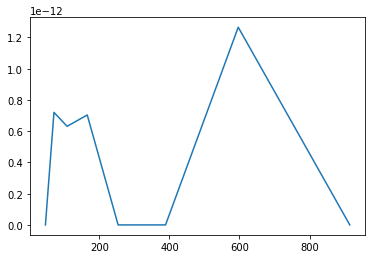

In [1146]:
plt.plot(ells, w_from_prime)

In [1110]:
def function(x):
    A0 = getA0v2(x)
    return np.array([A0.T@Z1@A0, A0.T@Z2@A0, A0.T@Z3@A0])

result = optimize.root(function, np.array([0., 0., 0.]), method = 'hybr', 
                       options = {'maxfev': 10000, 'xtol': 1e-4, 'ftol': 1e-20})

/home/r/rbond/omard/.local/lib/python3.6/site-packages/ipykernel_launcher.py:6: OptimizeWarning: Unknown solver options: ftol
  


In [1111]:
result

    fjac: array([[-0.1845615 , -0.00587346,  0.98280342],
       [-0.98086603, -0.0619399 , -0.18456784],
       [ 0.0619588 , -0.9980626 ,  0.00567064]])
     fun: array([ 4.96055172e-38, -6.30358846e-37,  2.42016379e-36])
 message: 'The solution converged.'
    nfev: 128
     qtf: array([ 2.37309236e-36, -4.56296414e-37,  6.45934974e-37])
       r: array([ 1.48840628e-39, -2.68261467e-41, -1.80435489e-38,  1.16094875e-42,
        5.40541663e-40,  9.86167271e-41])
  status: 1
 success: True
       x: array([-4.56384629e+05, -8.79416958e+07, -1.51336394e+04])

In [1093]:
AA = getA0(result.x)

In [1094]:
AA[0]*AA[1]*2/AA[5]**2

1.0000000000244442

In [1095]:
AA[0]*AA[2]*2/AA[4]**2

0.9999999999998727

In [1096]:
AA[1]*AA[2]*2/AA[3]**2

1.0000000000525846

In [1102]:
w_from_prime = (AA[0]+AA[1]+AA[2])**2/getNormStd(1)**2
w_from_prime

7.266959708038979e-13

In [1008]:
def functionscalar(x):
    return function(x).sum()

In [957]:
x0 = np.array([0., 0., 0.])
resultdiff = my.diffev(functionscalar, x0, ftol = 1e-16, gtol = 1000, maxiter = 1024**3, maxfun = 1024**3)

Optimization terminated successfully.
         Current function value: 0.000000
         Iterations: 1000
         Function evaluations: 4004


In [958]:
resultdiff

array([ 0.00400217, -0.01896953,  0.02248795])

In [959]:
functionscalar(resultdiff)

4.02290417927903e-12

In [960]:
functionscalar(x0)

6.781068985914357e-12

In [961]:
functionscalar(result.x)

6.561834307758401e-23

In [962]:
result

    fjac: array([[-1.52788397e-03, -9.96285560e-01, -8.60973171e-02],
       [ 2.36743033e-02, -8.61093238e-02,  9.96004373e-01],
       [ 9.99718557e-01,  5.16514883e-04, -2.37179316e-02]])
     fun: array([1.41610461e-24, 4.34991156e-24, 5.98523269e-23])
 message: 'The iteration is not making good progress, as measured by the \n  improvement from the last five Jacobian evaluations.'
    nfev: 80
     qtf: array([-9.48904249e-24,  5.92721367e-23, -1.62054006e-27])
       r: array([-1.08113487e-10, -1.24821386e-09, -9.24870975e-10, -3.55355443e-11,
       -1.59860730e-10,  1.00103392e-12])
  status: 4
 success: False
       x: array([-4.69436603e-02, -2.12043150e-04, -1.84000622e-05])

In [963]:
function(result.x)

array([1.41610461e-24, 4.34991156e-24, 5.98523269e-23])

In [964]:
result.x

array([-4.69436603e-02, -2.12043150e-04, -1.84000622e-05])

In [965]:
A0 = getA0(result.x)
A0

array([3.01402898e-08, 1.84643538e-10, 8.22808619e-07, 1.74313663e-08,
       2.22709184e-07, 3.33622813e-09])

In [966]:
A0[0]*A0[1]*2

1.1130419518994896e-17

In [967]:
A0[5]**2

1.1130418102890283e-17

In [968]:
A0 = getA0(resultdiff)
A0

array([-1.16725071e-06, -2.33676908e-07, -1.67293176e-06,  9.84360402e-07,
        2.78066884e-06, -7.44749132e-07])

In [913]:
A0[0]*A0[1]*2

0.006094021180574725

In [914]:
A0[5]**2

0.013021007552113486

In [915]:
getstandardA0()

array([3.02438463e-08, 1.88189519e-10, 8.22032609e-07, 1.75896516e-08,
       2.22986223e-07, 3.37389238e-09])

In [916]:
function(result.x)

array([8.20584173e-06, 2.55431313e-06, 4.96668656e-05])

In [917]:
mvVector = lambda_over_2*np.einsum('...ij, j -> ...i', invMandel, C)-FB*bias*np.einsum('...ij, ...j -> ...i', invMandel, Bvec)

In [63]:
Vec = 1/Norm*np.einsum('...ij, j -> ...i', invMandel, C)+FB*bias*np.einsum('...ij, ...j -> ...i', invMandel, (O/Norm)*C-Bvec)

In [64]:
AA = np.einsum('...ij, j -> ...i', invMandel, C)

In [65]:
index = 1

In [66]:
AA[index, 0]*AA[index, 1]*2/(AA[index, 5]**2)

1.0000000000464384

In [67]:
Bvec[index]

array([0.0056652 , 0.00294179, 0.00423567, 0.0048665 , 0.00601772,
       0.00671335])

In [68]:
C

array([1.        , 1.        , 1.        , 1.41421356, 1.41421356,
       1.41421356])

In [69]:
BB = np.einsum('...ij, ...j -> ...i', invMandel, Bvec)

In [70]:
BB[index, 0]*BB[index, 1]*2/(BB[index, 5]**2)

0.7212781737789982

In [73]:
Vec

array([[-1.44994979e-04, -8.20513850e-06, -2.04424744e-04,
         6.46332131e-05,  2.48317800e-04, -4.77557087e-05],
       [-9.70120933e-05, -1.22552332e-05, -1.78290951e-04,
         7.67736715e-05,  1.97598649e-04, -5.75265566e-05],
       [-4.95555499e-05, -2.95556825e-06, -6.29192083e-05,
         2.16475612e-05,  8.61908957e-05, -1.61637577e-05],
       [-1.06390661e-05, -4.26969260e-07, -3.99318637e-06,
         3.74136317e-06,  1.68229949e-05, -3.39412476e-06],
       [-6.19749229e-06, -1.83407688e-08, -6.07927980e-06,
         1.16519744e-06,  1.12877144e-05, -1.12192767e-06],
       [-1.02672514e-06, -1.70466699e-07, -2.04298487e-06,
         1.17877990e-06,  2.95384265e-06, -8.86408258e-07],
       [-2.02975271e-07,  4.29119239e-08, -3.06898133e-07,
         1.13080201e-07,  6.72892387e-07, -1.84313428e-07],
       [-3.85702994e-08, -1.04510403e-08, -2.22479673e-07,
         9.82974667e-08,  2.09198982e-07, -7.15535920e-08]])

In [72]:
mvVector.shape

(8, 6)

In [699]:
check = np.einsum('ij, ...j -> ...i', (P+np.sqrt(2)*Q), mvVector)
check = np.einsum('...i, i -> ...', check, E)
print(check.shape)
integrate_discrete(check, ells)

(8,)


1.000000000000006

In [700]:
noiseAL = np.einsum('...i, ...ij, ...j -> ...', mvVector, MandelMatrix, mvVector)
np.sqrt(integrate_discrete(noiseAL, ells))

0.008324484606545696

In [701]:
bias

1.1613386332893011e-07

In [702]:
selection = abs(mvVector)<1e-10
mvVector[selection] *= 0.

In [703]:
wLcalculated = mvVector[:, 0:3].sum(axis = 1)+np.sqrt(2)*mvVector[:, 3:6].sum(axis = 1)
wLcalculated

array([1.76071503e-05, 1.58141153e-05, 1.22961065e-05, 8.24911785e-06,
       3.58958007e-06, 1.43718319e-06, 4.80760753e-07, 1.41727943e-07])

In [704]:
integrate_discrete(wLcalculated, ells)

1.0000000000000062

In [705]:
mvVector[:, 0]+mvVector[:, 1]+mvVector[:, 2]+np.sqrt(2)*(mvVector[:, 3]+mvVector[:, 4]+mvVector[:, 5])

array([1.76071503e-05, 1.58141153e-05, 1.22961065e-05, 8.24911785e-06,
       3.58958007e-06, 1.43718319e-06, 4.80760753e-07, 1.41727943e-07])

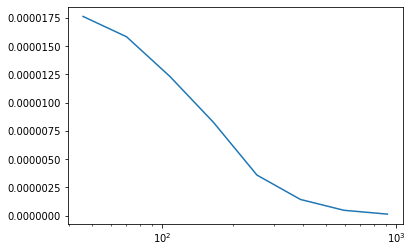

In [706]:
plt.plot(ells, wLcalculated)
plt.xscale('log')

In [707]:
mvVector[:, 0]

array([6.11161687e-06, 4.00463067e-06, 2.09114391e-06, 1.07778138e-06,
       3.81810343e-07, 6.11293933e-08, 7.56108644e-09, 8.52674483e-10])

In [708]:
mvVector[:, 1]

array([1.01803115e-06, 5.94625374e-07, 2.09062210e-07, 5.47366078e-08,
       2.02177199e-08, 2.75535117e-08, 5.34084846e-09, 7.13654733e-10])

In [709]:
mvVector[:, 2]

array([2.29586026e-05, 1.76490071e-05, 1.17091882e-05, 6.86190185e-06,
       2.67483835e-06, 1.28531545e-06, 4.67834906e-07, 1.40431772e-07])

In [710]:
mvVector[:, 3]

array([-3.89607518e-06, -2.24337954e-06, -9.97693162e-07, -3.90691674e-07,
       -1.34315296e-07, -1.31185183e-07, -4.05220569e-08, -5.40905758e-09])

In [711]:
mvVector[:, 4]

array([-7.71575471e-06, -3.89706952e-06, -9.22081192e-07,  3.42437144e-07,
        4.19586683e-07,  1.50813484e-07,  3.91335121e-08,  5.09177877e-09])

In [712]:
mvVector[:, 5]

array([2.78635920e-06, 1.59081950e-06, 7.08296925e-07, 2.28353219e-07,
       7.72719186e-08, 2.50501259e-08, 1.40545348e-09, 1.26247904e-10])

In [713]:
np.sqrt(mvVector[:, 0]*mvVector[:, 1]*2)

array([3.52755337e-06, 2.18231758e-06, 9.35071299e-07, 3.43494096e-07,
       1.24252441e-07, 5.80401491e-08, 8.98694797e-09, 1.10319099e-09])

In [714]:
a2 = mvVector[:, 5]**2/mvVector[:, 0]/wLcalculated/2
a1 = mvVector[:, 5]**2/mvVector[:, 1]/wLcalculated/2
a3 = mvVector[:, 3]**2/mvVector[:, 1]/wLcalculated/2

In [715]:
# Aprime = w*A

In [716]:
A1prime = np.sqrt(mvVector[..., 0]) 
A1prime

array([2.47216846e-03, 2.00115733e-03, 1.44607880e-03, 1.03816250e-03,
       6.17908038e-04, 2.47243591e-04, 8.69545079e-05, 2.92005905e-05])

In [717]:
A2prime = np.sqrt(mvVector[..., 1])
A2prime

array([1.00897530e-03, 7.71119559e-04, 4.57233212e-04, 2.33958560e-04,
       1.42189029e-04, 1.65992505e-04, 7.30811088e-05, 2.67143170e-05])

In [718]:
A3prime = np.sqrt(mvVector[..., 2])
A3prime

array([0.00479151, 0.00420107, 0.00342187, 0.00261952, 0.00163549,
       0.00113372, 0.00068398, 0.00037474])

In [719]:
print(np.sqrt(2)*A1prime*A2prime)
print(mvVector[..., 5])

[3.52755337e-06 2.18231758e-06 9.35071299e-07 3.43494096e-07
 1.24252441e-07 5.80401491e-08 8.98694797e-09 1.10319099e-09]
[2.78635920e-06 1.59081950e-06 7.08296925e-07 2.28353219e-07
 7.72719186e-08 2.50501259e-08 1.40545348e-09 1.26247904e-10]


In [720]:
print(np.sqrt(2)*A1prime*A3prime)
print(mvVector[..., 4])

[1.67519660e-05 1.18893023e-05 6.99794221e-06 3.84594073e-06
 1.42918225e-06 3.96410277e-07 8.41111189e-08 1.54753087e-08]
[-7.71575471e-06 -3.89706952e-06 -9.22081192e-07  3.42437144e-07
  4.19586683e-07  1.50813484e-07  3.91335121e-08  5.09177877e-09]


In [721]:
print(np.sqrt(2)*A2prime*A3prime)
print(mvVector[..., 3])

[6.83704216e-06 4.58138570e-06 2.21266752e-06 8.66714752e-07
 3.28874239e-07 2.66138890e-07 7.06913763e-08 1.41576692e-08]
[-3.89607518e-06 -2.24337954e-06 -9.97693162e-07 -3.90691674e-07
 -1.34315296e-07 -1.31185183e-07 -4.05220569e-08 -5.40905758e-09]


In [722]:
check = np.einsum('ij, ...j -> ...j', (P+np.sqrt(2)*Q), mvVector)
check = np.einsum('...i, i -> ...', check, E)
print(check.shape)
integrate_discrete(check, ells)

(8,)


1.000000000000006

In [723]:
invsigma2 = np.nan_to_num(theta[0, 0, 0, 0, :]**-1)
invsigma2[1] = 0.
factor = integrate_discrete(invsigma2, ells)
invvarweights_hu_ok = invsigma2*factor**-1

In [724]:
Optimizerkk = best.Opt(['hu_ok', 'shear', 'bh'], 30, 1200, ells, ells*0.+1., 
                       np.nan_to_num(theta), np.nan_to_num(B), np.nan_to_num(N))

In [725]:
optversion = {'weights_name': 'absbias', 'sum_biases_squared': False, 'abs_biases': True, 'bias_squared': False,
                      'color': 'purple', 'latexformula': '\sigma^2(\hat{A}_{\rm{comb}})+\left(\int_{\vec{L}}\vec{a}^TB\vec{a}\right)^2'}

In [467]:
result = Optimizerkk.optimize(optversion, method = 'diff-ev', gtol = 500 ,bounds = [-4, 4]
                              ,noisebiasconstr = False, fb = FB, inv_variance = False)

Start optimization with diff-ev
Doing for absbias
Generation 0 has ChiSquare: 0.000456
Generation 100 has ChiSquare: 0.000137
Generation 200 has ChiSquare: 0.000098
Generation 300 has ChiSquare: 0.000088
Generation 400 has ChiSquare: 0.000080
Generation 500 has ChiSquare: 0.000076
Generation 600 has ChiSquare: 0.000073
Generation 700 has ChiSquare: 0.000071
Generation 800 has ChiSquare: 0.000070
Generation 900 has ChiSquare: 0.000070
Generation 1000 has ChiSquare: 0.000070
Generation 1100 has ChiSquare: 0.000069
Generation 1200 has ChiSquare: 0.000069
Generation 1300 has ChiSquare: 0.000069
Generation 1400 has ChiSquare: 0.000069
Generation 1500 has ChiSquare: 0.000069
Generation 1600 has ChiSquare: 0.000069
Generation 1700 has ChiSquare: 0.000069
Generation 1800 has ChiSquare: 0.000069
Generation 1900 has ChiSquare: 0.000069
Generation 2000 has ChiSquare: 0.000069
Generation 2100 has ChiSquare: 0.000069
Generation 2200 has ChiSquare: 0.000069
Generation 2300 has ChiSquare: 0.000069
Ge

In [726]:
a1code, a2code, a3code, w = result.ws

In [727]:
w

array([1.76094368e-05, 1.58147032e-05, 1.22971389e-05, 8.24933033e-06,
       3.59026379e-06, 1.43709131e-06, 4.80650297e-07, 1.41684692e-07])

In [728]:
integrate_discrete(w, ells)

1.0

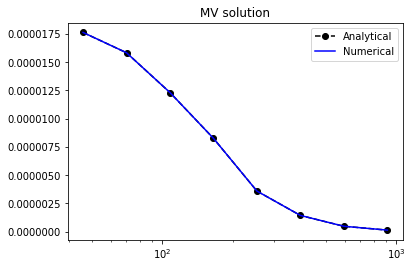

In [729]:
plt.title('MV solution')
plt.plot(ells, wLcalculated, ls = '--', label = 'Analytical', color = 'black', marker = 'o')
plt.plot(ells, w, label = 'Numerical', color = 'blue')
plt.xscale('log')
plt.legend()

In [730]:
w_from_prime = (A1prime+A2prime+A3prime)**2
w_from_prime

array([6.84368598e-05, 4.86275967e-05, 2.83575540e-05, 1.51448951e-05,
       5.73885323e-06, 2.39306554e-06, 7.12370093e-07, 1.85465609e-07])

In [731]:
a1 = np.nan_to_num(A1prime/np.sqrt(w_from_prime))
a2 = np.nan_to_num(A2prime/np.sqrt(w_from_prime))
a3 = np.nan_to_num(A3prime/np.sqrt(w_from_prime))
a1+a2+a3

array([1., 1., 1., 1., 1., 1., 1., 1.])

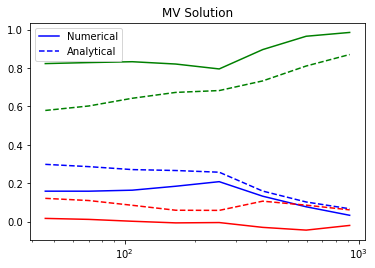

In [732]:
plt.title('MV Solution')

plt.plot(ells, a1code, color = 'blue', label = 'Numerical')
plt.plot(ells, a2code, color = 'red')
plt.plot(ells, a3code, color = 'green')

plt.plot(ells, a1, ls = '--', color = 'blue', label = 'Analytical')
plt.plot(ells, a2, ls = '--', color = 'red')
plt.plot(ells, a3, ls = '--', color = 'green')
plt.xscale('log')
plt.legend()

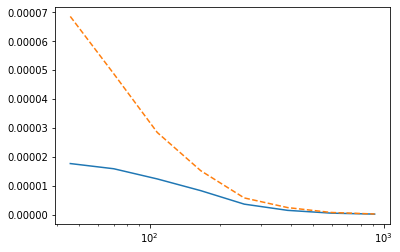

In [733]:
plt.plot(ells, w)
plt.plot(ells, w_from_prime, ls = '--')
plt.xscale('log')

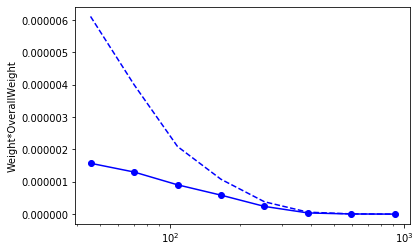

In [734]:
plt.plot(ells, a1**2*w, color = 'blue', marker = 'o')
#plt.plot(ells, a2**2*w, color = 'red', marker = 'o')
#plt.plot(ells, a3**2*w, color = 'green', marker = 'o')
plt.plot(ells, A1prime**2, ls = '--', color = 'blue')

plt.ylabel('Weight*OverallWeight')

#plt.plot(ells, A2prime**2, ls = '--', color = 'red')
#plt.plot(ells, A3prime**2, ls = '--', color = 'green')
plt.xscale('log')

In [477]:
K.shape

(6, 6)

In [ ]:
class AnalyticalConstrainedOpt():
    def __init__(self, ells, invM, Bvec, constrainted_components = [3, 4, 5]):
        '''
        M, Bvec already divided by Ckk^2, Ckk respectively
        '''
        
        self.E = np.ones(6)
        self.P = self.getP()
        self.Q = self.getQ()
        
        self.invM = invM
        self.B = Bvec
        
        self.K = self.P+np.sqrt(2)*self.Q
        
        self.ells = ells
        
        self.C = np.einsum('i, ij -> j', self.E.T, K)
        mvnorm = np.einsum('ij, ...jk, k, i -> ...', self.K, self.invM, self.C, self.E)
        self.mvnorm = self.integrate(mvnorm, self.ells)
        
        #int K M^-1 B dot E
        b_prefactor = np.einsum('ij, ...jk, ...k, i -> ...', self.K, self.invM, self.B, self.E)
        self.b_prefactor = self.integrate(b_prefactor, self.ells)
        
        lambda_i_prefactor = []
        for i in constrainted_components:
            temp = np.einsum('ij, ...jk, k, i', self.K, self.invM, self.getPi(i), self.E)
            lambda_i_prefactor += [self.integrate(temp, ells)]
        self.lambda_i_prefactor = np.array(lambda_i_prefactor)
        
        
        self.Lambda_lambda = np.einsum('...ij, k, kj -> ...i', self.invM, self.E.T, self.K)
        self.Lambda_b = np.einsum('...ij, ...j -> ...i', self.invM, self.B)
        
        self.Lambda_lambda_i = {}
        self.Lambda_lambda_i_list = []
        for i in constrainted_components:
            self.Lambda_lambda_i[i] = np.einsum('...ij, j -> ...i', self.invM, self.getPi(i))
            self.Lambda_lambda_i_list += [self.Lambda_lambda_i[i]]
            
        self.Lambda_lambda_i_list = np.array(self.Lambda_lambda_i_list)
        self.Lambda_lambda_i_list = np.rollaxis(self.Lambda_lambda_i_list, 0, self.Lambda_lambda_i_list.ndim)
            
        Ncomp = len(constrainted_components)
        Nells = len(self.ells)
        
        self.Cijs = np.zeros((Nells, Ncomp, Ncomp))
        for i, component in enumerate(constrainted_components):
            for j in range(Ncomp):
                self.Cijs[:, j, i] = self.Lambda_lambda_i[component][:, j] #Note order of index
                                
        self.invCijs = np.linalg.inv(self.Cijs)
        
        self.C_lambda = self.Lambda_lambda[:, 3:] #NOTE
        self.C_b = self.Lambda_b[:, 3:]
                
        self.super_b_prefactor = np.einsum('...ij, ...j,  i-> ...', self.invCijs, self.C_b, self.lambda_i_prefactor)
        
        self.super_lambda_prefactor = self.mvnorm+np.einsum('...ij, ...j,  i-> ...', self.invCijs, self.C_lambda, self.lambda_i_prefactor)
        
        
        
        
    def getPi(self, i):
        P = np.zeros(6)
        P[i] = 1
        return P
        
    def getP(self):
        P = np.zeros((6, 6))
        P[0, 0] = 1
        P[1, 1] = 1
        P[2, 2] = 1
        return P
    
    def getQ(self):
        Q = np.zeros((6, 6))
        Q[3, 3] = 1
        Q[4, 4] = 1
        Q[5, 5] = 1
        return Q
    
    
    
    
    def integrate(self, y, ells):
        factor = 4*np.pi
        return np.trapz(y*ells, ells)*(2*np.pi)/(2*np.pi)**2*factor

    

In [ ]:
A = AnalyticalConstrainedOpt(ells, invMandel, Bvec)